# Week 6: ODEs

In [1]:
import numpy as np
from numpy.linalg import eigvals
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# new packages for data fitting
import scipy.stats.qmc as lhs # for Latin Hypercube sampling (parameter scanning)
from scipy.interpolate import interp1d # for simulation interpolation in your scoring function
import scipy.optimize as opt # for constrained minimisation

# new package to help find steady states of limit cycle oscillators
from scipy.signal import find_peaks

# handy for checking paths in google colab:
#!ls -R

## 1 ODE

### 1.1 ODEs of the given reactions

$$
\frac{d[\mathrm{Glc}]}{dt} = - rφGlc
$$
$$
\frac{d[\mathrm{PEP}]}{dt} = rφ(Glc + OAA) + φPYR - PEP(1 + φ + d)
$$
$$
\frac{d[\mathrm{PYR}]}{dt} = rφOAA + φPEP - PYR(φ + d)
$$
$$
\frac{d[\mathrm{OAA}]}{dt} = PEP - φOAA
$$

𝜑 = max(1 - PYR, 𝜑(0))

fixed amount of glucose fed to the cells so Glc(0) = 1 mM

### 1.2 Code function for the given reactions

In [2]:
def ode_function(state, t, r, d, phi0):
    Glc, PEP, PYR, OAA = state

    # added dynamic phi, as described in the assignment
    phi = max(1 - PYR, phi0)

    dGlc_dt = - r * phi * Glc

    dPEP_dt = r * phi * (Glc + OAA) + phi * PYR - PEP * (1 + phi + d)

    dPYR_dt = r * phi * OAA + phi * PEP - PYR * (phi + d)

    dOAA_dt = PEP - phi * OAA

    return [dGlc_dt, dPEP_dt, dPYR_dt, dOAA_dt]

## 2 Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# I do not know if this works for you, but it connects the drive immediately with the data without needing to import them again

base_path = "/content/drive/My Drive/WUR/Modeling in Systems Biology/week_5/SSB Group Project/Code + Data/Data/"

file_r1 = base_path + "core_metabolism_r1.csv"
file_r01 = base_path + "core_metabolism_r01.csv"
file_r001 = base_path + "core_metabolism_r001.csv"

data_time, PEP_mean1, PEP_sd1, PYR_mean1, PYR_sd1 = np.loadtxt(file_r1, delimiter=",", unpack=True)
data_time, PEP_mean01, PEP_sd01, PYR_mean01, PYR_sd01 = np.loadtxt(file_r01, delimiter=",", unpack=True)
data_time, PEP_mean001, PEP_sd001, PYR_mean001, PYR_sd001 = np.loadtxt(file_r001, delimiter=",", unpack=True)

print("Loaded CSVs successfully!")


Mounted at /content/drive
Loaded CSVs successfully!


In [ ]:
# # Loading the data for all r values
# data_time, PEP_mean1, PEP_sd1, PYR_mean1, PYR_sd1 = np.loadtxt("./core_metabolism_data/core_metabolism_r1.csv",delimiter=",",unpack=True)
# data_time, PEP_mean01, PEP_sd01, PYR_mean01, PYR_sd01 = np.loadtxt("./core_metabolism_data/core_metabolism_r01.csv",delimiter=",",unpack=True)
# data_time, PEP_mean001, PEP_sd001, PYR_mean001, PYR_sd001 = np.loadtxt("./core_metabolism_data/core_metabolism_r001.csv",delimiter=",",unpack=True)

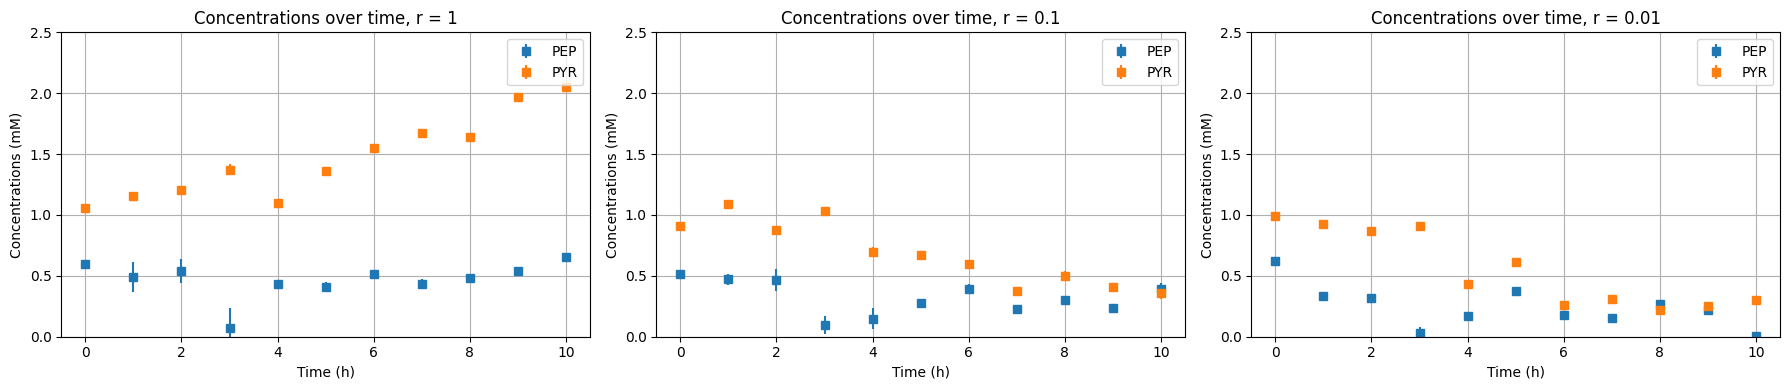

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))   # 1 row, 3 columns


# --- r = 1 ---
axs[0].errorbar(data_time, PEP_mean1, PEP_sd1, marker='s', linestyle='', label='PEP')
axs[0].errorbar(data_time, PYR_mean1, PYR_sd1, marker='s', linestyle='', label='PYR')
axs[0].set_xlabel('Time (h)')
axs[0].set_ylabel('Concentrations (mM)')
axs[0].set_title('Concentrations over time, r = 1')
axs[0].set_ylim(0,2.5)
axs[0].grid(True)
axs[0].legend()

# --- r = 0.1 ---
axs[1].errorbar(data_time, PEP_mean01, PEP_sd01, marker='s', linestyle='', label='PEP')
axs[1].errorbar(data_time, PYR_mean01, PYR_sd01, marker='s', linestyle='', label='PYR')
axs[1].set_xlabel('Time (h)')
axs[1].set_ylabel('Concentrations (mM)')
axs[1].set_title('Concentrations over time, r = 0.1')
axs[1].set_ylim(0,2.5)
axs[1].grid(True)
axs[1].legend()

# --- r = 0.01 ---
axs[2].errorbar(data_time, PEP_mean001, PEP_sd001, marker='s', linestyle='', label='PEP')
axs[2].errorbar(data_time, PYR_mean001, PYR_sd001, marker='s', linestyle='', label='PYR')
axs[2].set_xlabel('Time (h)')
axs[2].set_ylabel('Concentrations (mM)')
axs[2].set_title('Concentrations over time, r = 0.01')
axs[2].set_ylim(0,2.5)
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()


In [ ]:
IC_r1 = [PEP_mean1[0], PYR_mean1[0]]
IC_r01 = [PEP_mean01[0], PYR_mean01[0]]
IC_r001 = [PEP_mean001[0], PYR_mean001[0]]
print(IC_r1)
print(IC_r01)
print(IC_r001)

[np.float64(0.5959767043680678), np.float64(1.0539206163517314)]
[np.float64(0.5117541474271133), np.float64(0.911833211989625)]
[np.float64(0.6236555824782992), np.float64(0.9912989696358654)]


In [ ]:
from scipy.integrate import solve_ivp

def simulate_model(params, r, t_eval):
    """
    Simulates the 4-ODE metabolic model.

    params : list or array
        [d, phi0, P0, Y0, A0]
    r      : float
        given growth parameter (0.01, 0.1, or 1)
    t_eval : array
        timepoints at which data were recorded (e.g. data_time)
    """

    d, phi0, P0, Y0, A0 = params
    G0 = 1.0   # fixed by problem description

    # Initial state vector
    y0 = [G0, P0, Y0, A0]

    # Solve ODE
    sol = solve_ivp(
        lambda t, y: ode_function(y, t, r, d, phi0),
        t_span=[t_eval[0], t_eval[-1]],
        y0=y0,
        t_eval=t_eval,
        max_step=0.1
    )

    # return PEP, PYR
    PEP_pred = sol.y[1]
    PYR_pred = sol.y[2]

    return PEP_pred, PYR_pred


In [ ]:
def residuals(params, r, data_time, pep_mean, pyr_mean):
    """
    Computes residuals between model predictions and experimental data.

    params     : array-like [d, phi0, P0, Y0, A0]
    r          : float (growth parameter, e.g. 1, 0.1, 0.01)
    data_time  : array of timepoints
    pep_mean   : experimental PEP mean values
    pyr_mean   : experimental PYR mean values
    """

    # Simulate the model with these parameters
    pep_pred, pyr_pred = simulate_model(params, r, data_time)

    # residuals for least_squares → 1-D concatenated vector
    res_pep = pep_pred - pep_mean
    res_pyr = pyr_pred - pyr_mean

    return np.concatenate([res_pep, res_pyr])


In [ ]:
from scipy.optimize import least_squares

# --------------------------
# Parameter bounds
# params = [d, phi0, P0, Y0, A0]
# --------------------------
lower_bounds = [1e-9, 0.0, 0.0, 0.0, 0.0]
upper_bounds = [1e-6, 1.0, 10.0, 10.0, 10.0]

# Initial guess (reasonable starting point)
initial_guess = [1e-7, 0.2, 1.0, 1.0, 1.0]

# --------------------------
# Fit for r = 0.01
# --------------------------
r_val = 0.01

result_r001 = least_squares(
    fun=residuals,
    x0=initial_guess,
    bounds=(lower_bounds, upper_bounds),
    args=(r_val, data_time, PEP_mean001, PYR_mean001),
    max_nfev=5000
)

print("Fitting completed for r = 0.01")
print("Estimated parameters:")
print(result_r001.x)
print("\nResidual norm:", result_r001.cost)


Fitting completed for r = 0.01
Estimated parameters:
[1.00000000e-09 1.25072535e-01 6.54045709e-01 1.02211859e+00
 1.00000000e+01]

Residual norm: 0.13196125740859038


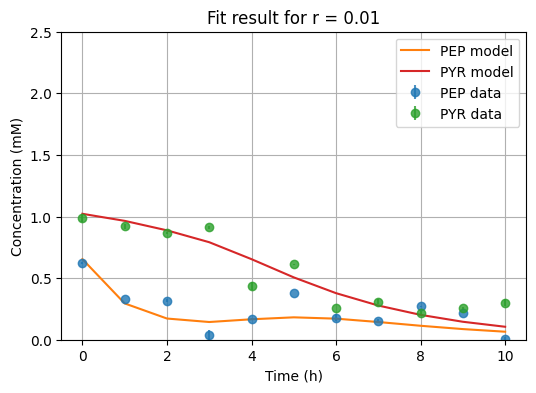

In [ ]:
# Extract fitted parameters
d_fit, phi0_fit, P0_fit, Y0_fit, A0_fit = result_r001.x

# Simulate model using fitted parameters
pep_pred, pyr_pred = simulate_model(
    params=result_r001.x,
    r=r_val,
    t_eval=data_time
)

# Plot comparison to data
plt.figure(figsize=(6,4))

# PEP
plt.errorbar(data_time, PEP_mean001, PEP_sd001, fmt='o', label="PEP data", alpha=0.8)
plt.plot(data_time, pep_pred, '-', label="PEP model")

# PYR
plt.errorbar(data_time, PYR_mean001, PYR_sd001, fmt='o', label="PYR data", alpha=0.8)
plt.plot(data_time, pyr_pred, '-', label="PYR model")

plt.xlabel("Time (h)")
plt.ylabel("Concentration (mM)")
plt.title("Fit result for r = 0.01")
plt.ylim(0, 2.5)
plt.grid(True)
plt.legend()
plt.show()


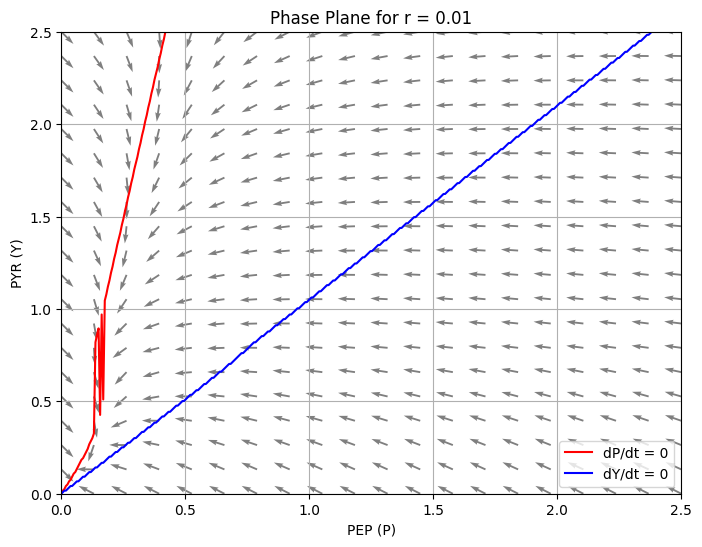

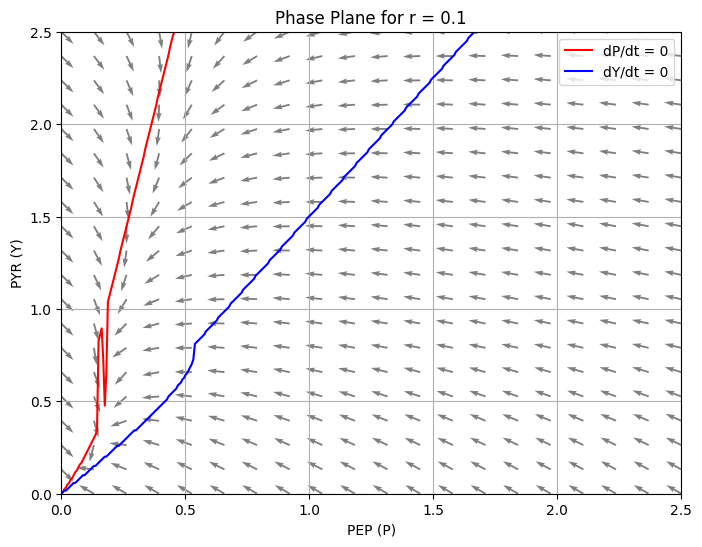

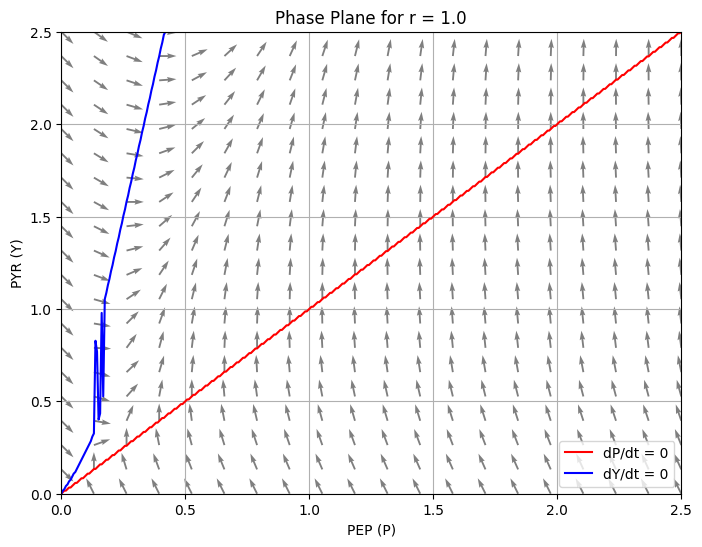

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Parameters from Task 1
# (Update these with YOUR fitted values if needed)
# -------------------------------------------------------
d = 1e-7        # degradation
phi0 = 0.2      # minimum energy state

# -------------------------------------------------------
# Energy function
# -------------------------------------------------------
def phi(Y):
    return np.maximum(1 - Y, phi0)

# -------------------------------------------------------
# Reduced model
# -------------------------------------------------------
def dPdt(P, Y, r):
    ph = phi(Y)
    return r*P + ph*Y - P*(1 + ph + d)

def dYdt(P, Y, r):
    ph = phi(Y)
    return P*(r + ph) - Y*(ph + d)

# -------------------------------------------------------
# Function to compute and plot phase plane for a given r
# -------------------------------------------------------
def plot_phase_plane(r):
    P_vals = np.linspace(0, 2.5, 400)
    Y_vals_Pnull = []
    Y_vals_Ynull = []

    # Compute nullclines
    for P in P_vals:
        Ys = np.linspace(0, 2.5, 300)

        fP = [abs(dPdt(P, Y, r)) for Y in Ys]
        fY = [abs(dYdt(P, Y, r)) for Y in Ys]

        Y_vals_Pnull.append(Ys[np.argmin(fP)])
        Y_vals_Ynull.append(Ys[np.argmin(fY)])

    # Vector field
    P_grid, Y_grid = np.meshgrid(np.linspace(0, 2.5, 20),
                                 np.linspace(0, 2.5, 20))
    dP = dPdt(P_grid, Y_grid, r)
    dY = dYdt(P_grid, Y_grid, r)

    norm = np.sqrt(dP**2 + dY**2)
    dP_norm = dP / (norm + 1e-9)
    dY_norm = dY / (norm + 1e-9)

    # Plot
    plt.figure(figsize=(8,6))
    plt.title(f"Phase Plane for r = {r}")

    plt.quiver(P_grid, Y_grid, dP_norm, dY_norm, alpha=0.5)

    plt.plot(P_vals, Y_vals_Pnull, 'r-', label="dP/dt = 0")
    plt.plot(P_vals, Y_vals_Ynull, 'b-', label="dY/dt = 0")

    plt.xlabel("PEP (P)")
    plt.ylabel("PYR (Y)")
    plt.xlim(0, 2.5)
    plt.ylim(0, 2.5)
    plt.grid(True)
    plt.legend()
    plt.show()

# -------------------------------------------------------
# Produce all three phase planes
# -------------------------------------------------------
for r in [0.01, 0.1, 1.0]:
    plot_phase_plane(r)


In [ ]:
def nullclines(ode, pars, xlim, ylim, labels = ['Nullcline x','Nullcline y'], npointsx = 100, npointsy = 100):
    x_range = np.linspace(xlim[0],xlim[1],npointsx)
    y_range = np.linspace(ylim[0],ylim[1],npointsy)
    X,Y = np.meshgrid(x_range,y_range)

    dXdt = ode([X,Y],0,*pars)
    dxdt = dXdt[0]
    dydt = dXdt[1]

    C = plt.contour(X,Y,dxdt, levels = [0], colors = ['cyan'])
    plt.plot([],[],color = 'cyan',label = labels[0])

    C = plt.contour(X,Y,dydt, levels = [0], colors = ['red'], linestyles = ['--'])
    plt.plot([],[],color = 'red', linestyle = '--', label = labels[1])
    plt.xlabel('$x$')
    plt.ylabel('$y$')

$$
\frac{d[\mathrm{PEP}]}{dt} = rPEP + φPYR - PEP(1 + φ + d)
$$
$$
\frac{d[\mathrm{PYR}]}{dt} = rPEP + φPEP - PYR(φ + d)
$$

$$
\frac{d[\mathrm{PEP}]}{dt} = PEP(r - φ - d -1) + φPYR
$$
$$
\frac{d[\mathrm{PYR}]}{dt} = PEP(r + φ) - PYR(φ + d)
$$

In [ ]:
def ode_function2(state, t, r, d, phi0):
    PEP, PYR = state

    # added dynamic phi, as described in the assignment
    phi = np.maximum(1 - PYR, phi0)

    dGlc_dt = 0

    dPEP_dt = r * PEP + phi * PYR - PEP * (1 + phi + d)

    dPYR_dt = r * PEP + phi * PEP - PYR * (phi + d)

    return [dPEP_dt, dPYR_dt]

In [ ]:
def pplane(ode, pars, xlim, ylim, npointsx = 13, npointsy = 13, rescale_arrows = True):
    x_range = np.linspace(xlim[0],xlim[1],npointsx)
    y_range = np.linspace(ylim[0],ylim[1],npointsy)
    X,Y = np.meshgrid(x_range,y_range)

    dXdt = ode([X,Y],0,*pars)

    U = np.copy(dXdt[0])
    V = np.copy(dXdt[1])
    if rescale_arrows:
        length = np.sqrt(U**2 + V**2)
        with np.errstate(divide='ignore', invalid='ignore'):
            U /= length
            V /= length

    plt.quiver(X,Y,U,V, angles = 'xy', scale_units = 'xy', pivot = 'mid')

d = 1.0000000000038864e-09
phi0 = 0.12507253518978736


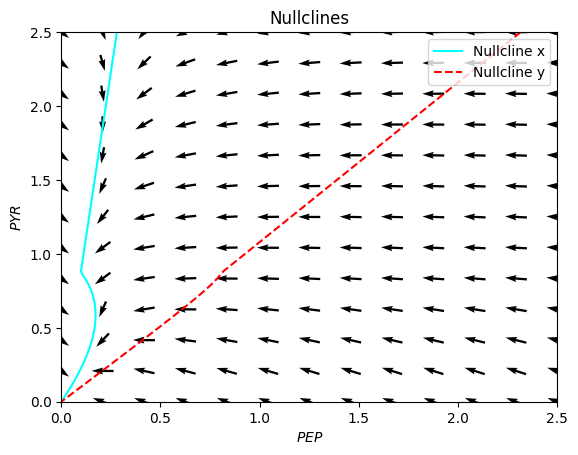

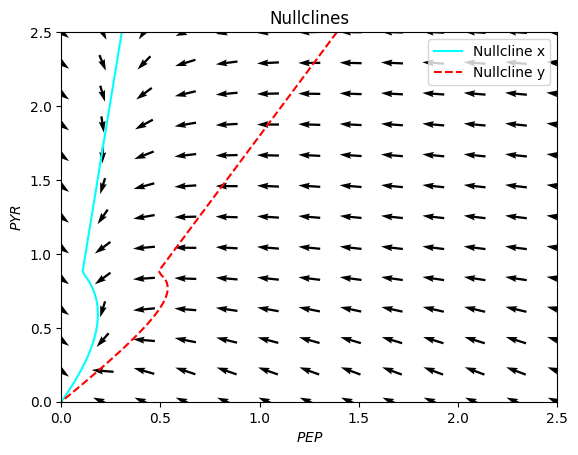

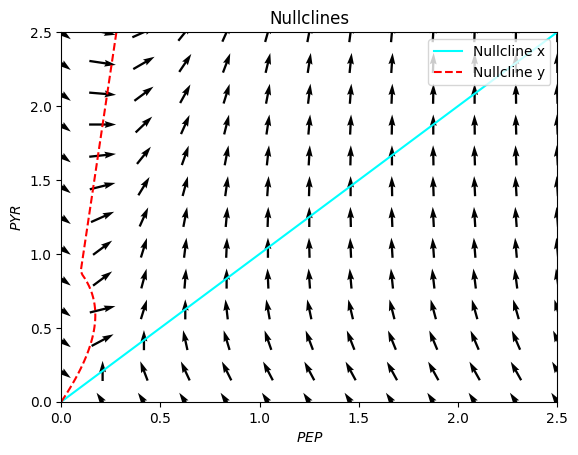

"\nt_values = np.linspace(0,3,301)\nPEP = - (PYR * phi) / (r - 1 - phi - d)\nPYR = (PEP * (r + phi)) / (phi + d)\n\nxlim = (0,3)\nylim = (0,3)\n\nnullclines(ode_function, parameters_fitted_r1, xlim, ylim)\n\nplt.plot(t_values,y1, ':', label = 'Analytical nullcline x')\nplt.plot(x,y2, ':', label = 'Analytical nullcline y')\n\nplt.xlabel('x')\nplt.ylabel('y')\nplt.legend(loc='upper right')\nplt.show()\n"

In [ ]:
d_fit, phi0_fit, P0_fit, Y0_fit, A0_fit = result_r001.x

r1 = 1
r01 = 0.1
r001 = 0.01
parameters_fitted_r1 = [r1, d_fit, phi0_fit]
parameters_fitted_r01 = [r01, d_fit, phi0_fit]
parameters_fitted_r001 = [r001, d_fit, phi0_fit]
print(f"d = {d_fit}")
print(f"phi0 = {phi0_fit}")

xlim = (0,2.5)
ylim = (0,2.5)
t_values = np.linspace(0,3,301)

plt.clf()
nullclines(ode_function2, parameters_fitted_r001, xlim, ylim)
pplane(ode_function2, parameters_fitted_r001, xlim, ylim)

plt.title("Nullclines")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

plt.clf()
nullclines(ode_function2, parameters_fitted_r01, xlim, ylim)
pplane(ode_function2, parameters_fitted_r01, xlim, ylim)

plt.title("Nullclines")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

plt.clf()
nullclines(ode_function2, parameters_fitted_r1, xlim, ylim)
pplane(ode_function2, parameters_fitted_r1, xlim, ylim)

plt.title("Nullclines")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

"""
t_values = np.linspace(0,3,301)
PEP = - (PYR * phi) / (r - 1 - phi - d)
PYR = (PEP * (r + phi)) / (phi + d)

xlim = (0,3)
ylim = (0,3)

nullclines(ode_function, parameters_fitted_r1, xlim, ylim)

plt.plot(t_values,y1, ':', label = 'Analytical nullcline x')
plt.plot(x,y2, ':', label = 'Analytical nullcline y')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.show()
"""

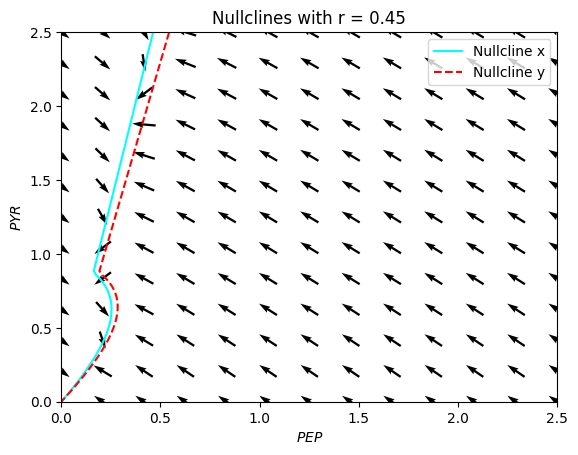

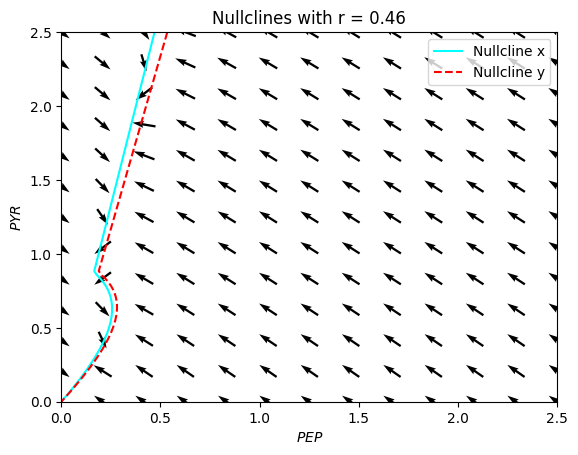

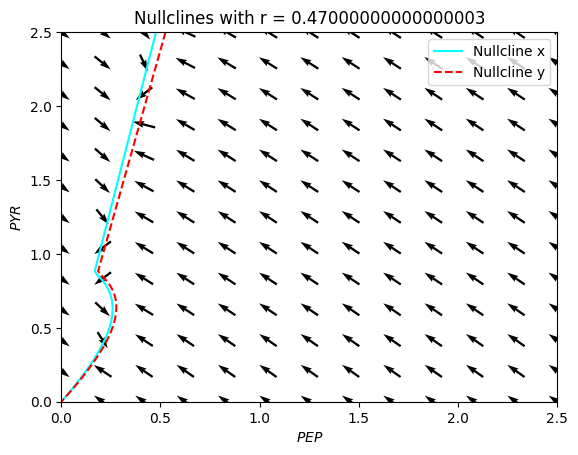

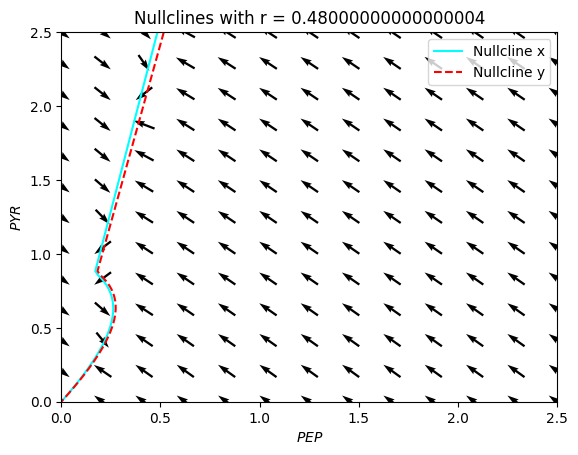

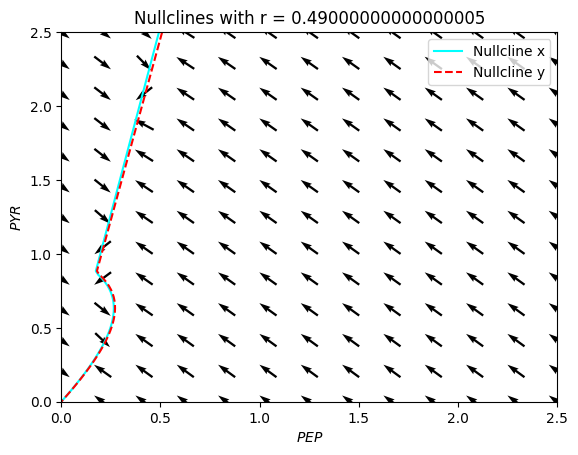

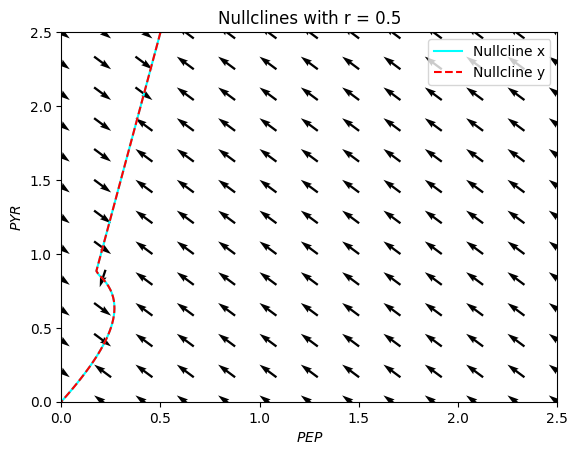

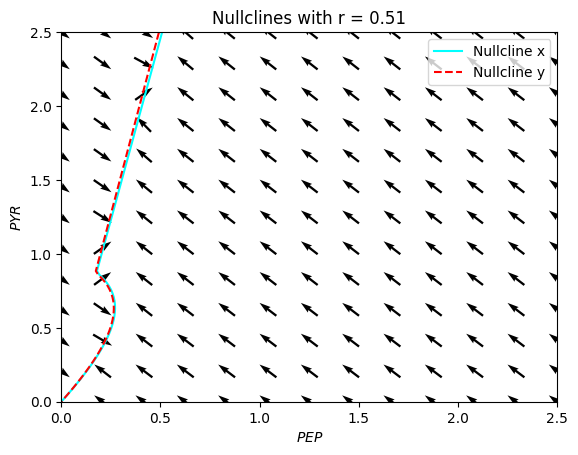

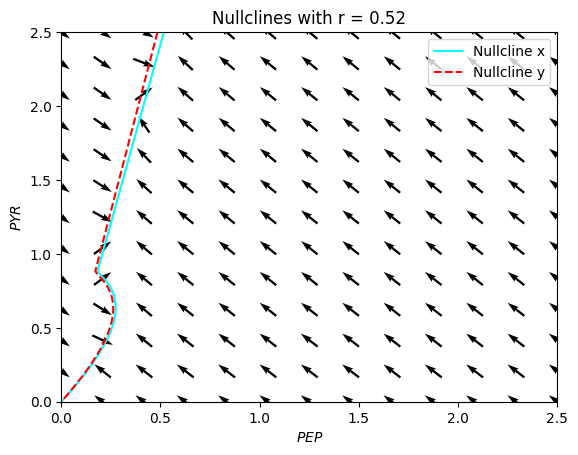

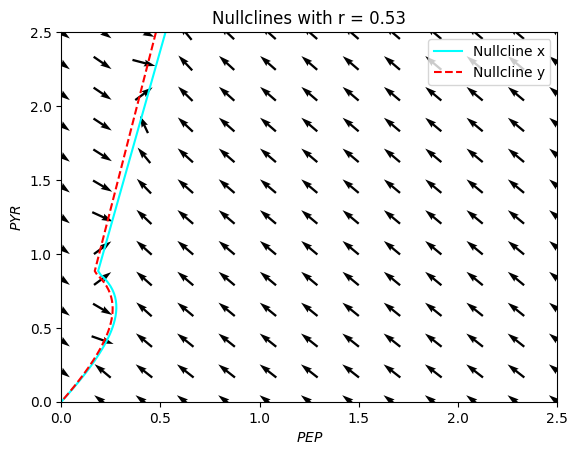

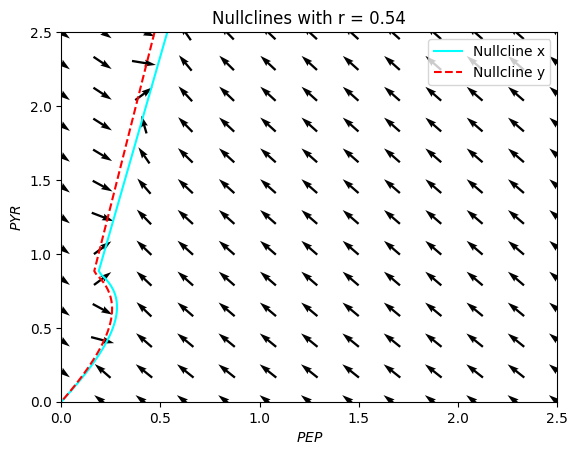

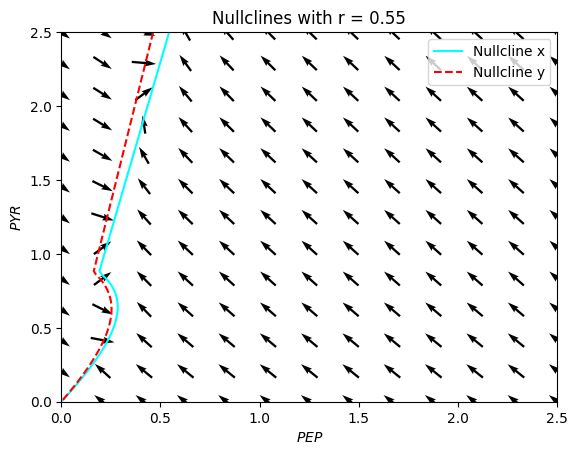

In [ ]:
r_range = np.linspace(0.45, 0.55, 11)
for r in r_range:
  parameters_fitted_r = [r, d_fit, phi0_fit]
  xlim = (0,2.5)
  ylim = (0,2.5)

  plt.clf()
  nullclines(ode_function2, parameters_fitted_r, xlim, ylim)
  pplane(ode_function2, parameters_fitted_r, xlim, ylim)

  plt.title(f"Nullclines with r = {r}")
  plt.xlabel('$PEP$')
  plt.ylabel('$PYR$')
  plt.legend()
  plt.show()

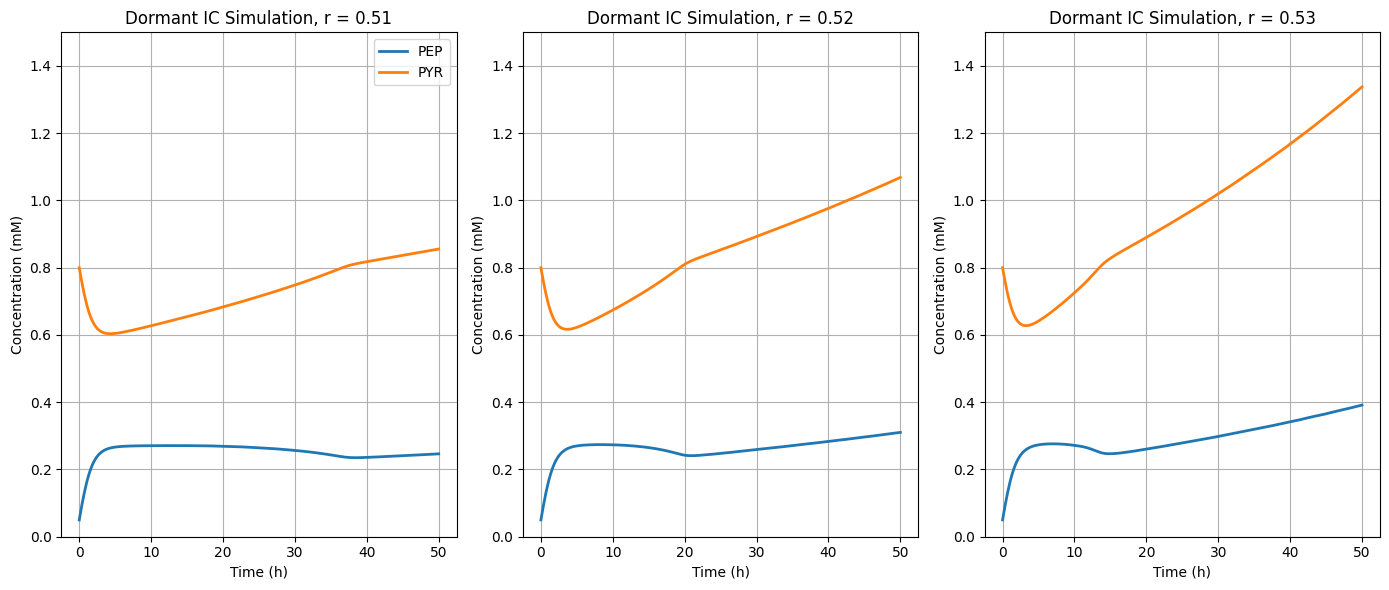

In [ ]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------
# Simulation function (already defined)
# -------------------------------------------------------
def simulate(P0, Y0, r=0.1, T=50):
    sol = solve_ivp(
        lambda t, y: [dPdt(y[0], y[1], r), dYdt(y[0], y[1], r)],
        t_span=[0, T],
        y0=[P0, Y0],
        t_eval=np.linspace(0, T, 300)
    )
    return sol.t, sol.y[0], sol.y[1]


# -------------------------------------------------------
# Dormant initial conditions
# -------------------------------------------------------
P0 = 0.05   # extremely low PEP
Y0 = 0.8    # high PYR → low φ (ATP/ADP)


# -------------------------------------------------------
# Simulate for r = 0.01, 0.1, 1.0
# -------------------------------------------------------
r_values = [0.51, 0.52, 0.53]

plt.figure(figsize=(14,6))

for i, r in enumerate(r_values):
    t, P, Y = simulate(P0, Y0, r=r, T=50)

    plt.subplot(1, 3, i+1)
    plt.plot(t, P, label="PEP", linewidth=2)
    plt.plot(t, Y, label="PYR", linewidth=2)
    plt.title(f"Dormant IC Simulation, r = {r}")
    plt.xlabel("Time (h)")
    plt.ylabel("Concentration (mM)")
    plt.ylim(0, 1.5)
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def simplified_model_phi0(state, t, r, d, phi0):
    PEP, PYR = state

    # added dynamic phi, as described in the assignment
    phi = phi0

    dPEP_dt = r * PEP + phi * PYR - PEP * (1 + phi + d)

    dPYR_dt = r * PEP + phi * PEP - PYR * (phi + d)

    return [dPEP_dt, dPYR_dt]

In [ ]:
def simplified_model_1_PYR(state, t, r, d, phi0):
    PEP, PYR = state

    # added dynamic phi, as described in the assignment
    phi = 1 - PYR

    dPEP_dt = r * PEP + phi * PYR - PEP * (1 + phi + d)

    dPYR_dt = r * PEP + phi * PEP - PYR * (phi + d)

    return [dPEP_dt, dPYR_dt]

## Phase plane analysis

2 models: 1 for phi = phi(0) and 1 for phi = 1 - PYR

In [ ]:
OAAinit = 1.011495
d_fit = 1.084762e-09
phi0_fit = 0.136305

r1 = 1
r01 = 0.1
r001 = 0.01
parameters_fitted_r1 = [r1, d_fit, phi0_fit]
parameters_fitted_r1 = [r01, d_fit, phi0_fit]
parameters_fitted_r1 = [r001, d_fit, phi0_fit]
xlim = (-2, 2)
ylim = (-2, 2)

a = r1 - 1 - phi0_fit - d_fit
b = phi0_fit
c = r1 + phi0_fit
d = - phi0_fit - d_fit
print(r1 - 1 - phi0_fit - d_fit)
print(- phi0_fit - d_fit)
print(r1 + phi0_fit)
print(b*c)

-0.136305001084762
-0.136305001084762
1.1363050000000001
0.15488405302500002


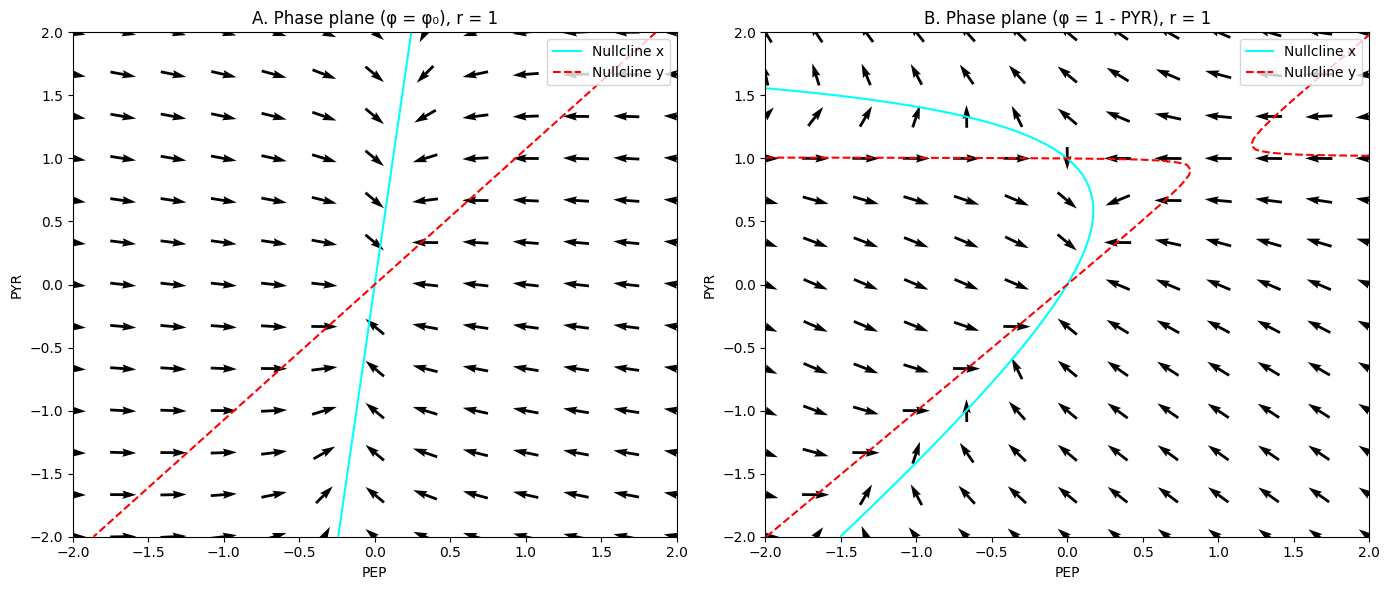

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Left plot: phi = phi0 ---
plt.sca(axes[0])
nullclines(simplified_model_phi0, parameters_fitted_r1, xlim, ylim)
pplane(simplified_model_phi0, parameters_fitted_r1, xlim, ylim)

plt.title(f"A. Phase plane (φ = φ₀), r = {r1}")
plt.xlabel("PEP")
plt.ylabel("PYR")
plt.legend()

# --- Right plot: phi = 1 - PYR ---
plt.sca(axes[1])
nullclines(simplified_model_1_PYR, parameters_fitted_r1, xlim, ylim)
pplane(simplified_model_1_PYR, parameters_fitted_r1, xlim, ylim)

plt.title(f"B. Phase plane (φ = 1 - PYR), r = {r1}")
plt.xlabel("PEP")
plt.ylabel("PYR")
plt.legend()

plt.tight_layout()
plt.show()


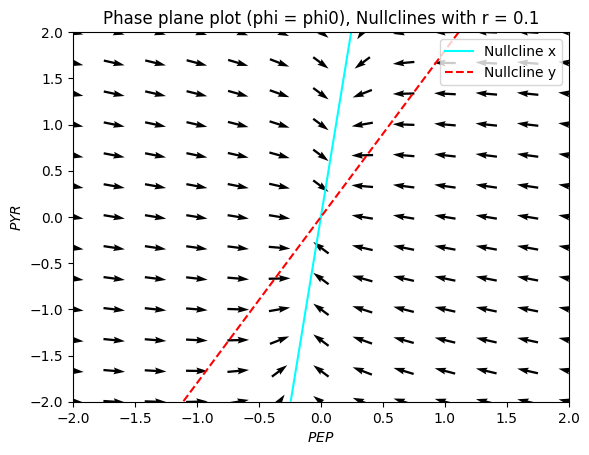

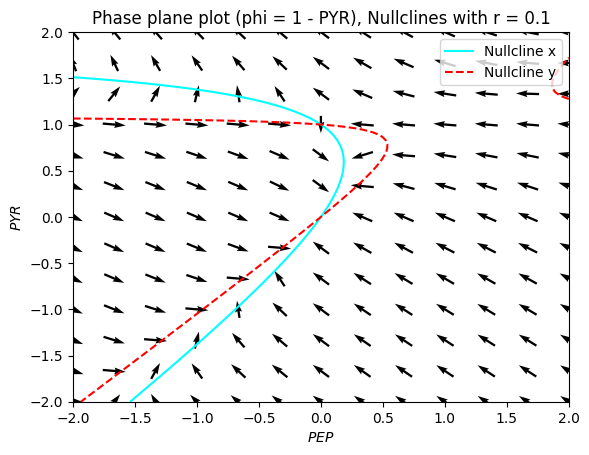

In [ ]:
plt.clf()
nullclines(simplified_model_phi0, parameters_fitted_r01, xlim, ylim)
pplane(simplified_model_phi0, parameters_fitted_r01, xlim, ylim)

plt.title(f"Phase plane plot (phi = phi0), Nullclines with r = {r01}")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

plt.clf()
nullclines(simplified_model_1_PYR, parameters_fitted_r01, xlim, ylim)
pplane(simplified_model_1_PYR, parameters_fitted_r01, xlim, ylim)

plt.title(f"Phase plane plot (phi = 1 - PYR), Nullclines with r = {r01}")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

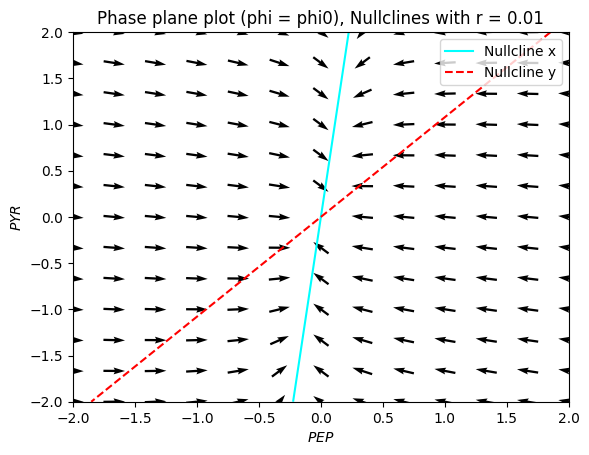

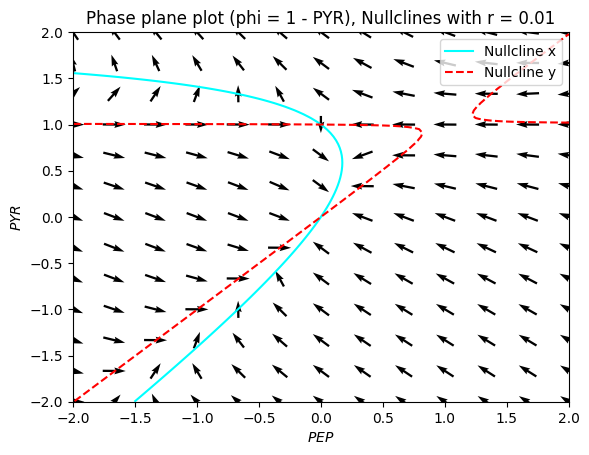

In [ ]:
plt.clf()
nullclines(simplified_model_phi0, parameters_fitted_r001, xlim, ylim)
pplane(simplified_model_phi0, parameters_fitted_r001, xlim, ylim)

plt.title(f"Phase plane plot (phi = phi0), Nullclines with r = {r001}")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

plt.clf()
nullclines(simplified_model_1_PYR, parameters_fitted_r001, xlim, ylim)
pplane(simplified_model_1_PYR, parameters_fitted_r001, xlim, ylim)

plt.title(f"Phase plane plot (phi = 1 - PYR), Nullclines with r = {r001}")
plt.xlabel('$PEP$')
plt.ylabel('$PYR$')
plt.legend()
plt.show()

In [ ]:
# --------------------------
# Nonlinear model with phi(P)
# --------------------------

def phi_nonlin(P, phi0, alpha, K):
    """
    Nonlinear energy status:
        phi(P) = phi0 + alpha * P / (K + P)
    """
    return phi0 + alpha * P / (K + P + 1e-12)  # small eps to avoid div by zero

def rhs_nonlinear(t, z, r, d, phi0, alpha, K):
    P, Y = z
    phi = phi_nonlin(P, phi0, alpha, K)

    dP = 2*r*phi - phi*P + phi*Y - (1 + d)*P
    dY = r*phi + phi*P - phi*Y - d*Y
    return [dP, dY]


In [ ]:
r = 0.1          # same as before
d = 1e-7
phi0 = 0.05      # low baseline energy
alpha = 0.8      # strong feedback from P
K = 0.5          # P scale


In [ ]:
# --------------------------
# Phase plane for nonlinear model
# --------------------------

def plot_phase_plane_nonlinear(r, d, phi0, alpha, K,
                               P_range=(0, 5.0), Y_range=(0, 5.0),
                               n_grid=20, t_span=(0, 100), n_traj=7):
    P_min, P_max = P_range
    Y_min, Y_max = Y_range

    P = np.linspace(P_min, P_max, n_grid)
    Y = np.linspace(Y_min, Y_max, n_grid)
    PP, YY = np.meshgrid(P, Y)

    dPdt = np.zeros_like(PP)
    dYdt = np.zeros_like(YY)

    for i in range(n_grid):
        for j in range(n_grid):
            dPdt[j, i], dYdt[j, i] = rhs_nonlinear(
                0, [PP[j, i], YY[j, i]], r, d, phi0, alpha, K
            )

    norm = np.sqrt(dPdt**2 + dYdt**2)
    norm[norm == 0] = 1.0
    dPdt_norm = dPdt / norm
    dYdt_norm = dYdt / norm

    plt.figure()
    plt.quiver(PP, YY, dPdt_norm, dYdt_norm, alpha=0.5)
    plt.xlabel("P (PEP)")
    plt.ylabel("Y (PYR)")
    plt.title(f"Nonlinear phase plane, phi0={phi0}, alpha={alpha}, K={K}")

    # Sample trajectories
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    rng = np.random.default_rng(1)

    for _ in range(n_traj):
        P0 = rng.uniform(P_min, P_max)
        Y0 = rng.uniform(Y_min, Y_max)
        sol = solve_ivp(rhs_nonlinear, t_span, [P0, Y0],
                        args=(r, d, phi0, alpha, K),
                        t_eval=t_eval)
        plt.plot(sol.y[0, :], sol.y[1, :], linewidth=1)

    plt.xlim(P_min, P_max)
    plt.ylim(Y_min, Y_max)
    plt.grid(True)
    plt.show()




In [ ]:
# --------------------------
# Wake-up experiment
# --------------------------

def wake_up_experiment():
    # Dormant initial condition (very low P, Y)
    P0_dormant, Y0_dormant = 0.01, 0.01
    t_eval = np.linspace(0, 200, 2000)

    # Trajectory starting fully dormant
    sol_dormant = solve_ivp(rhs_nonlinear, (0, 200),
                            [P0_dormant, Y0_dormant],
                            args=(r, d, phi0, alpha, K),
                            t_eval=t_eval)

    # Slightly "kicked" initial condition (e.g. temporary nutrient pulse)
    P0_kick, Y0_kick = 0.6, 0.1
    sol_kick = solve_ivp(rhs_nonlinear, (0, 200),
                         [P0_kick, Y0_kick],
                         args=(r, d, phi0, alpha, K),
                         t_eval=t_eval)

    plt.figure()
    plt.plot(sol_dormant.t, sol_dormant.y[0, :], label="P(t) dormant start")
    plt.plot(sol_kick.t, sol_kick.y[0, :], label="P(t) kicked start")
    plt.xlabel("time")
    plt.ylabel("P (PEP)")
    plt.title("Wake-up experiment in nonlinear model")
    plt.legend()
    plt.grid(True)
    plt.show()




### Python version

In [ ]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


### Scoring function formula (latest practical)

$$
\Omega(p) = \sum_{i \in \delta = \{0.04, 1.24, 1.7\}} \sum_{j \in \{N, C, B\}}
\omega_{i,j}(p)
$$
$$
\omega_{i,j}(p) = \sum_{t=t_1}^{t_f}
\frac{(D_{i,j}(t) - M_{i,j}(t; p))^2}{\sigma_{i,j}(t)^2}
$$

### Our scoring function formula

$$
\Omega(p) = \sum_{i \in r = \{0.01, 0.1, 1\}} \sum_{j \in \{PEP, PYR\}}
\omega_{i,j}(p)
$$
$$
\omega_{i,j}(p) = \sum_{t=t_0}^{t_f}
\frac{(D_{i,j}(t) - M_{i,j}(t; p))^2}{\sigma_{i,j}(t)^2}
$$

p = (d, ϕ0​, OAA(0)​)